# Eddy Fluxes of Buoyancy
In these notes I try to summarize how the buoyancy eddy fluxes are generally thought about and parameterized.  
 
Buoyancy evolves according to
\begin{equation}
\partial_t b + \mathbf{u}\cdot \nabla b = S + \kappa_m \nabla^2 b.
\end{equation}
In nature $\kappa_m$ is the molecular diffusion, while in a numerical model the last term on the RHS can be thought of as a crude representation of the numerical dissipation. 


In [66]:
import xlayers
import numpy as np
import pandas as pd
# load modules 
from xlayers import finegrid, layers
from xlayers.core import layers_numpy
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
from xgcm import Grid
%matplotlib inline
import xarray as xr

In [22]:
dir_zarr = '/swot/SUM04/dbalwada/channel_model/05km_sponge/run_tracers_restored_3day_output/run_tracers_restored_zarr/'
ds_model = xr.open_zarr(dir_zarr)

The figures below show the solution of a numerical model (5km MITgcm Channel Output). It is clear that there is a lot of spatial and temporal variability, and this variability would increase at finer and finer details are resolved. 

The rate of increase of this variability will depend on the spectra, and nature of turbulence etc. 

The main point is that there is a lot of variability, and a researcher might not be particularly interested in all the high frequency variations that are present and only care about some slowly evolving mean. This might lead one to try and estimate how some mean properties evolve.  

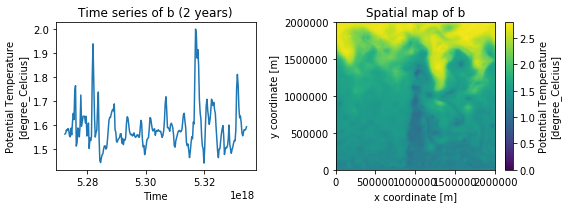

In [29]:
plt.figure(figsize=(8,3))

plt.subplot(121)
ds_model.T.sel(XC=0, YC=1000e3, Z =-1000, method='nearest').isel(time=slice(0,240)).plot()
plt.title('Time series of b (2 years)')

plt.subplot(122)
ds_model.T.sel(Z =-1000, method='nearest').isel(time=-1).plot()
plt.title('Spatial map of b')

plt.tight_layout()

One might try to do an average over a few months (as shown below). 

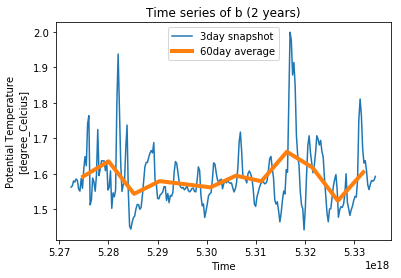

In [36]:
Tser60 = ds_model.T.sel(XC=0, YC=1000e3, Z =-1000, method='nearest').isel(time=slice(0,240)).coarsen(time=20, boundary='trim').mean()

ds_model.T.sel(XC=0, YC=1000e3, Z =-1000, method='nearest').isel(time=slice(0,240)).plot(label='3day snapshot')
Tser60.plot(linewidth=4,label='60day average')
plt.title('Time series of b (2 years)')
plt.legend()

### Mean buoyancy balance 

As expected this time average has less variability. Now we might be interested in understanding how this average evolves, which can be understood by writing an equation for the evolution of the average ($\overline{b}$) by doing a Reynold's decomposition 
\begin{equation}
b = \overline{b} + b',
\end{equation}
which gives
\begin{equation}
\partial_t \overline{b} + \overline{\mathbf{u}}\cdot \nabla \overline{b} = - \nabla \cdot \overline{\mathbf{u}'b'} + \overline{S} + \kappa_m \nabla^2 \overline{b} .
\end{equation}

This equation for the mean has an additional forcing on the RHS, which results from the divergence of the eddy buoyancy fluxes ($\overline{\mathbf{u}'b'}$). This implies that the evolution of the mean buoyancy is governed not simply by what the mean variables (like mean flow or mean forcing) are doing, but also can depend on how the correlations of the perturbations are shaped. 

If we had a method/algorithm for representing $\nabla \cdot \overline{\mathbf{u}'b'} = f(mean-variables)$, then we could directly solve for $\overline{b}$, and not have to waste a lot of resources solving the buoyancy equation at fine resolution.


**The research of eddy parameterizations is research into how to best diagnose and represent these fluxes. **

This notebook looks at some properties of these fluxes, with a particular focus on mesoscale eddies. One of the properties of mesoscale eddies is that they don't cause signficant overturning in the ocean (they have low vertical shear, and large Richardson number), and so the associated motions are adiabatic - this adiabaticity should reflect in their fluxes. This property means that if watermasses are the same/constant along isopycnals, then mesoscale eddies will not cause any watermass transformation; since watermass transformation in this case would require there to be diapycnal mixing. 

What does it mean to be adiabatic physically? 
- The eddies can not change the volume contained in between any two isopycnals, or in any particular density class.
- They can however move isopycnals around, or flatten them to release APE. 

A way to mathematically represent adiabaticity for instantaneous flow would imply that $Db/Dt = 0$. 
However, it is clear that even in the adiabatic and unforced system ($\kappa_m=0, S=0$), the mean buoyancy does not evolve in an adiabatic sense following the mean flow, as $\overline{D}\overline{b}/Dt = -\nabla \cdot \overline{\mathbf{u}'b'}$, and a forcing remains on the RHS.

In [63]:
# Calculate the buoyancy budget with full time average
ds_mean = ds_model.mean('time')

In [70]:
grid =Grid(ds_mean, periodic='X')

In [81]:
div_mean = (grid.interp(ds_mean.U*grid.diff(ds_mean['T'], 'X')/ds_mean.dxC, 'X') + 
            grid.interp(ds_mean.V*grid.diff(ds_mean['T'], 'Y', boundary='extend')/ds_mean.dyC, 'Y', boundary='extend') 
            - grid.interp(ds_mean.W*grid.diff(ds_mean['T'], 'Z', boundary='extend'), 'Z', boundary='extend')/ds_mean.drF)

In [86]:
UpTp = ((ds_model.U - ds_mean.U)*grid.interp(ds_model['T'] - ds_mean['T'],'X')).mean('time')
VpTp = ((ds_model.V - ds_mean.V)*grid.interp(ds_model['T'] - ds_mean['T'],'Y', boundary='extend')).mean('time')
WpTp = ((ds_model.W - ds_mean.W)*grid.interp(ds_model['T'] - ds_mean['T'],'Z', boundary='extend')).mean('time')

In [89]:
div_eddy = (grid.diff(UpTp, 'X')/ds_mean.dxC[0,0] + grid.diff(VpTp,'Y', boundary='extend')/ds_mean.dyC[0,0] - 
            grid.diff(WpTp, 'Z', boundary='extend')/ds_mean.drF)

In [92]:
div_mean.load()
div_eddy.load()

<xarray.DataArray (Z: 40, YC: 400, XC: 400)>
array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-6.79436951e-08, -7.25761069e-08, -7.65210757e-08, ...,
         -5.78544714e-08, -6.48196092e-08, -6.60954456e-08],
        [-1.02200765e-07, -9.91871971e-08, -1.01483167e-07, ...,
         -8.74995294e-08, -9.61334905e-08, -9.86843531e-08],
        ...,
        [ 5.91032929e-08,  6.15904270e-08,  6.38226823e-08, ...,
          5.76537253e-08,  5.80821400e-08,  5.88059983e-08],
        [ 4.53934916e-08,  4.43214816e-08,  4.42184742e-08, ...,
          5.13206473e-08,  5.12710052e-08,  4.83940461e-08],
        [ 2.93077473e-09, -2.03270289e-09, -3.63906838e-09, ...,
          3.53236151e-09,  6.46663700e-09,  6.27301056e-09]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-6.13663005e-08, -6.60789823e-08, -6.97522609e-08

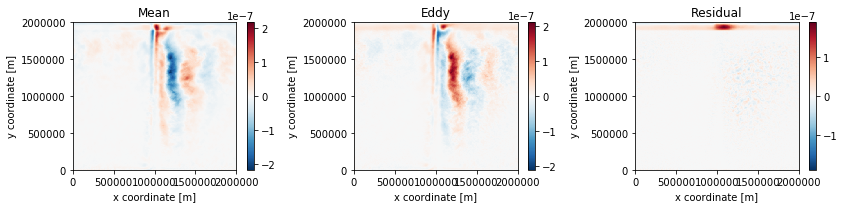

In [99]:
plt.figure(figsize=(12,3))

plt.subplot(131)
div_mean.sel(Z=-1000, method='nearest').plot()
plt.title('Mean')

plt.subplot(132)
div_eddy.sel(Z=-1000, method='nearest').plot()
plt.title('Eddy')

plt.subplot(133)
(div_mean+div_eddy).sel(Z=-1000, method='nearest').plot()
plt.title('Residual')
plt.tight_layout()

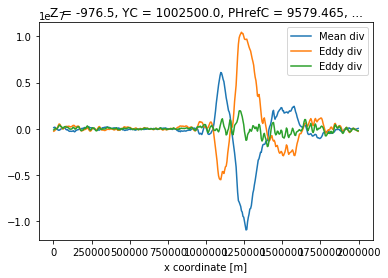

In [100]:
div_mean.sel(YC=1000e3, Z=-1000, method='nearest').plot(label='Mean div')
div_eddy.sel(YC=1000e3, Z=-1000, method='nearest').plot(label='Eddy div')
(div_mean+div_eddy).sel(YC=1000e3, Z=-1000, method='nearest').plot(label='Eddy div')

plt.legend()

### The variance equation 

One can still ask whether $\overline{\mathbf{u}'b'}$ is adiabatic relative to the mean in any sense, is $\overline{\mathbf{u}'b'} \cdot \nabla \overline{b} = 0$? This is akin to asking whether the eddy flux vector is aligned with the mean isopycnals? or the part of the flux perpendicular to the mean isopycnals is zero.

In an adiabatic flow, this term is not generally zero, as can be seen based on the equation for the buoyancy variance: 
\begin{equation}
\partial_t \phi + \nabla \cdot ( \overline{\mathbf{u}\phi} + .. ) = -\overline{\mathbf{u}'b'} \cdot \nabla \overline{b} - \kappa_m \overline{|\nabla b' |^2},
\end{equation}
where $\phi = \overline{b'^2}/2$. So for the buoyancy equation to balance, some part of the flux has to be across the mean isopycnals, atleast if there is a variance transport (even if the tendency is small). 

In [117]:
Tp = (ds_model['T'] - ds_mean['T'])

UTpTp =  (ds_model.U*grid.interp(Tp*Tp/2, 'X') ).mean('time')
VTpTp =  (ds_model.V*grid.interp(Tp*Tp/2, 'Y', boundary='extend')).mean('time')
WTpTp =  (ds_model.W*grid.interp(Tp*Tp/2, 'Z', boundary='extend')).mean('time')

In [118]:
div_var_transp = (grid.diff(UTpTp, 'X')/ds_mean.dxC[0,0] + 
                  grid.diff(VTpTp, 'Y', boundary='extend')/ds_mean.dyC[0,0] - 
                  grid.diff(WTpTp, 'Z', boundary='extend')/ds_mean.drF)

In [120]:
var_prod = (grid.interp(UpTp*grid.diff(ds_mean['T'], 'X')/ds_mean.dxC[0,0], 'X') + 
            grid.interp(VpTp*grid.diff(ds_mean['T'], 'Y', boundary='extend')/ds_mean.dyC[0,0], 'Y', boundary='extend') -
            grid.interp(WpTp*grid.diff(ds_mean['T'], 'Z', boundary='extend'), 'Z', boundary='extend')/ds_model.drF)

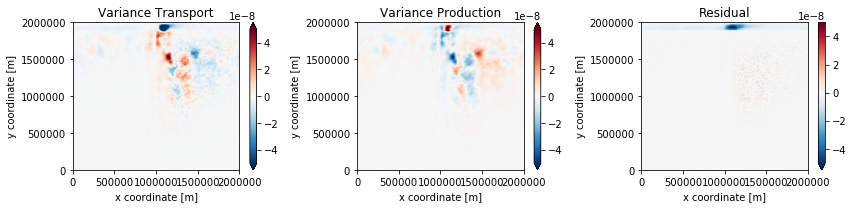

In [122]:
plt.figure(figsize=(12,3))

plt.subplot(131)
div_var_transp.sel(Z=-1000, method='nearest').plot(vmin=-5e-8)
plt.title('Variance Transport')

plt.subplot(132)
var_prod.sel(Z=-1000, method='nearest').plot(vmin=-5e-8)
plt.title('Variance Production')

plt.subplot(133)
(div_var_transp+var_prod).sel(Z=-1000, method='nearest').plot(vmin=-5e-8)
plt.title('Residual')

plt.tight_layout()

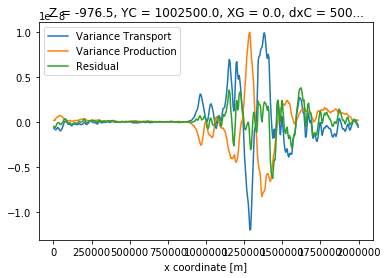

In [125]:
div_var_transp.sel(YC=1000e3, Z=-1000, method='nearest').plot(label='Variance Transport')
var_prod.sel(YC=1000e3, Z=-1000, method='nearest').plot(label='Variance Production')
(div_var_transp+var_prod).sel(YC=1000e3, Z=-1000, method='nearest').plot(label='Residual')
plt.legend()

It turns out that the dominant balance is between the transport and the production term, and the residual is small. This is to be expected because we are taking a long time average and the model is almost adiabatic in the interior. 

This implies that in this system having a cross-isopycnal flux is unavoidable. The question then is whether this flux needs to be parameterized if we only care about the mean buoyancy equation? This is the question that was at the heart of the McDougall and McIntosh 1996 and 2001 papers. 

These papers were written to provide theoretical support to the Gent and McWilliams (GM) parameterization. To go further, we first need to understand a key property of the GM parameterization. 

### The Gent-McWilliams Parameterization

GM came up with their parameterization because models in the times prior to this were too diffusive and would mix up water masses, specially in regions of sloping isopycnals. The story goes that they first tried to fix this problem by rotating the diffusion along the isopycnals (Redi diffusion). This was great and fixed some problems, but it was quickly realized that the problem with the method was that the effect of the eddies (the diffusion in the model) had no impact on buoyancy surface. So the eddies which remove the APE did not do this in their parameterization form. So, the solution that was devised was to add an extra advection to the buoyancy equation. This would not mix buoyancy, but could still move boluses around and flatten isopycnals. 

So the model equation (where $\overline{b}$ is the variable being solved for) went to being 
\begin{equation}
\partial_t \overline{b} + \overline{\mathbf{u}} \cdot \nabla \overline{b} - \overline{S} + \kappa_m \nabla^2 \overline{b} = -\mathbf{u}^* \cdot \nabla \overline{b}  =  \nabla \cdot ( \mathbf{A} \nabla \overline{b}).
\end{equation}
Here $\mathbf{u}^*$ is the extra advection, which can also be written in terms of the antisymmetric tensor $\mathbf{A}$. This is the choice of the way in which the parameterization would be done, the actual parameterization now was a choice of how this extra velocity would be implemented. The choice was to parameterize this as a streamfunction that depends on an eddy diffusion and the isopycnal slope $\psi = - K s$ 

(**Note**: that it is key to distinguish between the form of the parameterization - as an extra advection - and the choice of the parameterization - as a function of the isopycnal slope.) 

A very important thing to note here is that when the flux written as this antisymmetric tensor, lies purely in the plane of the mean isopycnal :  $\mathbf{A} \nabla \overline{b} \cdot \nabla \overline{b} =0$. This means that this flux does not take any part in the balance of the buoyancy variance equation. 

### The parallel-perpendicular flux decomposition 

The above discussion suggests that it is useful to decompose the tracer flux into two parts, a part parallel to the isopycnals and a part perpendicular to isopycnals:
\begin{equation}
\overline{\mathbf{u}'b'} = \mathbf{F}^b = \mathbf{F}^b_{||} + \mathbf{F}^b_{\perp},
\end{equation}

The two components are
\begin{equation}
\mathbf{F}_\perp = (\mathbf{F}. \mathbf{n}) \mathbf{n}, \qquad \mathbf{F}_\parallel = (\mathbf{n} \times \mathbf{F}) \times \mathbf{n},
\end{equation}
where 
\begin{equation}
\mathbf{n} = \frac{\nabla \overline{b}}{|\nabla \overline{b}|}.
\end{equation}

The parallel component is also referred to as the skew flux, which is what is being parameterized. One property of this flux is that its divergence can be written in purely advective form using the indentity $\nabla . (\mathbf{A} \times \nabla \phi) = \nabla \phi. (\nabla \times \mathbf{A})$ :

\begin{equation}
\nabla.(\mathbf{F}_\parallel)  = (\nabla \times (\mathbf{n} \times F)).\mathbf{n} = \left(\nabla \times \frac{\mathbf{n} \times F}{|\nabla \overline{b}|}\right).\nabla \overline{b} = (\nabla \times \mathbf{\psi^*}). \nabla \overline{b} = \mathbf{v^*}. \nabla \overline{b}
\end{equation}



In [129]:
Fbmod = (grid.interp(UpTp**2,'X') + grid.interp(VpTp**2,'Y',boundary='extend') 
         + grid.interp(WpTp**2, 'Z', boundary='extend'))**0.5

T_x = grid.interp(grid.diff(ds_mean['T'], 'X')/ ds_mean.dxC, 'X')
T_y = grid.interp(grid.diff(ds_mean['T'], 'Y', boundary='extend')/ ds_mean.dyC, 'Y', boundary='extend')
T_z = -grid.interp(grid.diff(ds_mean['T'], 'Z', boundary='extend'), 'Z', boundary='extend')/ ds_mean.drF

gradbmod = (T_x**2 + T_y**2 + T_z**2)**0.5

In [138]:
Fb_perp_mod = (grid.interp(UpTp,'X')*T_x + grid.interp(VpTp,'Y',boundary='extend')*T_y + 
               grid.interp(WpTp,'Z', boundary='extend')*T_z) / gradbmod
Fb_perp_x = Fb_perp_mod*T_x / gradbmod
Fb_perp_y = Fb_perp_mod*T_y / gradbmod
Fb_perp_z = Fb_perp_mod*T_z / gradbmod

In [141]:
Fb_para_x = grid.interp(UpTp, 'X') - Fb_perp_x
Fb_para_y = grid.interp(VpTp, 'Y', boundary='extend') - Fb_perp_y
Fb_para_z = grid.interp(WpTp, 'Z', boundary='extend') - Fb_perp_z

In [142]:
Fb_perp = xr.Dataset({'UpCp':Fb_perp_x, 'VpCp':Fb_perp_y, 'WpCp':Fb_perp_z})
Fb_para = xr.Dataset({'UpCp':Fb_para_x, 'VpCp':Fb_para_y, 'WpCp':Fb_para_z})

In [143]:
def divergence(flux, grid, Lcoarse):
    
    div = grid.interp(grid.diff(flux.UpCp, 'X')/Lcoarse, 'X') + \
              grid.interp(grid.diff(flux.VpCp, 'Y', boundary='extend')/Lcoarse, 'Y', boundary='extend') + \
             -grid.interp(grid.diff(flux.WpCp, 'Z', boundary='extend'), 'Z', boundary='extend')/ flux.drF
                
    return div           

In [145]:
Fb_para_div = divergence(Fb_para, grid, 5e3)
Fb_perp_div = divergence(Fb_perp, grid, 5e3)

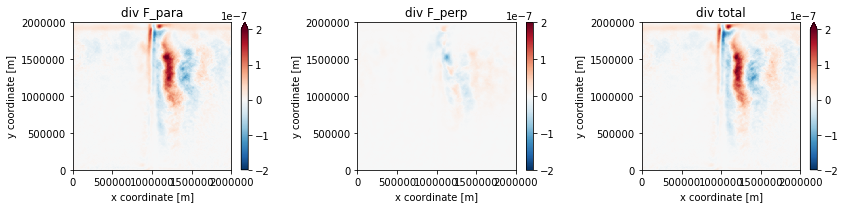

In [149]:
plt.figure(figsize=(12,3))

plt.subplot(131)
Fb_para_div.sel(Z=-1000, method='nearest').plot(vmin=-2e-7)
plt.title('div F_para')

plt.subplot(132)
Fb_perp_div.sel(Z=-1000, method='nearest').plot(vmin=-2e-7)
plt.title('div F_perp')

plt.subplot(133)
(Fb_para_div + Fb_perp_div).sel(Z=-1000, method='nearest').plot(vmin=-2e-7)
plt.title('div total')

plt.tight_layout()

We note that the divergence of the perpendicular flux is small, even though it is this flux vector that played the dominant role in the variance equation. This implies that the mean b equation is dominantly forced by the divergence of the parallel flux. This is what GM assumes. (*This is all in the context of a long time average*)

This is the result that the **Temporal Residual Mean** papers are after theoretically - can all the eddy forcing in the mean buoyancy equation be written as an extra advection. 

## Temporal Residual Mean (TRM)

There are two papers. TRM1 in 1996 and TRM2 in 2001. The main difference between the two is the averaging style. Both papers are quite hard to read, atleast it has taken me over a year to understand what the point of them is. 

#### TRM 1
The first paper performs a simple averaging, and the averaged variables are time averages at fixed Z points. The key result of this paper is that the the buoyancy equation can be written as  (equation 22):
\begin{equation}
\partial_t \overline{b} + \overline{\mathbf{u}} \cdot \nabla \overline{b} =  \overline{S} + \kappa_m \nabla^2 \overline{b}  +\nabla \cdot (\mathbf{A} \nabla \overline{b}) - \nabla \cdot \mathbf{N} - \nabla \cdot (E\mathbf{k}) + O(\alpha^3). 
\end{equation} 
where $\mathbf{N}$ is a non-divergence vector, and $E$ is zero if the flow is adiabatic and steady. So, if the flow is adaibatic, steady and unforced, we get 
\begin{equation}
\partial_t \overline{b} + \overline{\mathbf{u}} \cdot \nabla \overline{b} = \nabla \cdot(\mathbf{A} \nabla \overline{b}) + O(\alpha^3), 
\end{equation} 
which is the same form as the one assumed by GM. Also in the steady adiabatic case, it is the non-divergent vector $\mathbf{N}$ that closes the variance budget (as had been anticipated, and shown with assumptions in Marshall and Shutts 1981). The detailed formulae for the different terms are present in equations 11, 17, 19 and 21 in MM1996. 

This is a really nice result, and really helps cement GM parameterization. There is however a problem here. This it the term $E\mathbf{k}$. E goes to zero only for a steady flow, thus if the flow varies in time, then the GM parameterization will be unable to capture all the tracer flux (or atleast to $O(\alpha^2)$), since this part of the flux is vertical and will definitely have a component across the isopycnals. 


#### TRM 2 

The second paper was written to figure out whether under some special averaging all the eddy flux divergence can be written using an antisymmetric tensor, or how to ensure that E does not appear even if the flow unsteady. This is done because we know that mesoscale eddies are adiabatic even as they spin around, so one might crudely anticipate that under some framework this adaibaticity can be maintained. 

It was found that infact a special averaging does exist. If averaging is done in isopycnal frame then eddy motions that are adiabatic always remain adiabatic (seems a bit obvious in hindsight). MM2001 did exactly this, but in a slightly circuitous way. They transformed from Z to $\rho$ and back to $Z$ in a single step (which is part of the reason for the confusion). It was important for them to come back to a Z coordinate, because they were thinking about the GM parameterization, which is a parameterization for Z level models. 

They defined a new buoyancy variable, $\tilde{b} (z_a)$, which has an average height of $z_a$. (In TRM1 we averaged buoyancy at a single z, now in TRM2 we are sticking to a single buoyancy and asking that what is the average height at which this lives). 

It was shown that this new variable evolved according to (equation 23 in MM2001): 
\begin{equation}
\partial_t \tilde{b} + \overline{\mathbf{u}} \cdot \nabla \tilde{b} =  \overline{S} + \kappa_m \nabla^2 \tilde{b}  +\nabla \cdot (\mathbf{A} \nabla \tilde{b}) - \nabla \cdot \mathbf{N} + O(\alpha^3). 
\end{equation} 
The amazing thing about this is that the buoyancy flux is composed only of a part that is parallel to isopycnals (can be parameterized in GM) and a part that is non-divergent. Unsteadiness does not show up as an extra eddy divergence. 

$\mathbf{N}$ is the bit that balances the variance equation, and plays no role in forcing the mean buoyancy equation. 

$\mathbf{A}$ is composed of a stream function, the Quasi-stokes stream function. This stream function has a physical meaning, and accounts for the extra volume transport that takes place deeper than a specific isopycnal due to correlations between isopycnal heaving and velocity (equation 4a and 4b). 

Also, the $O(\alpha^3)$ are only present if the model is not being evaluated following isopycnals, it appears due to an approximation that is done. 

This paper also showed that since the above buoyancy equation can be derived, if one was to be using the "perfect GM parameterization", then the corresponding density variable in the model should be interpreted not as a time average but instead the Z levels in the model should be interpreted as the mean depth of an isopycnal. 


#### Further ... 
and some analysis in the model. 

Lets decompose the flux into its parts in both ways. 

### TRM1 calculations 
So in TRM1 the flux is written as 
\begin{equation}
\overline{\mathbf{u}'b'} = - \mathbf{A} \nabla \overline{b} + \mathbf{N} + E\mathbf{k} + O(\alpha^3)  
\end{equation} 

where psi vector is 
$$ \mathbf{A} \nabla \overline{b} = \psi^x \overline{b}_z \mathbf{i} + \psi^y \overline{b}_z \mathbf{j} + (-\psi^x \overline{b}_x -\psi^y \overline{b}_y)  \mathbf{k}$$ 
and 
$$\mathbf{\psi} = - \frac{\overline{\mathbf{V}'b'}}{\overline{b}_z} + \frac{1}{\overline{b}_z} (\frac{\overline{\mathbf{V}} . \overline{\phi}}{\overline{b}_z})_z $$

so 
\begin{equation}
\mathbf{A} \nabla \overline{b} = 
\end{equation}

the non-divergent flux is 
\begin{equation}
\mathbf{N} = \nabla \times [\frac{\overline{\mathbf{V}} . \overline{\phi}}{\overline{b}_z} \times \mathbf{k} ] 
\end{equation}


In [155]:
phi = (Tp*Tp/2).mean('time')

psix = - grid.interp(UpTp, 'X')/T_z + 1/T_z* grid.interp(grid.diff( 
                            grid.interp(ds_mean.U,'X')*phi/T_z, 'Z', boundary='extend'), 'Z',boundary='extend')/ (-ds_mean.drF)
psiy = - grid.interp(VpTp, 'Y', boundary='extend')/T_z + 1/T_z* grid.interp(grid.diff( 
                            grid.interp(ds_mean.V,'Y',boundary='extend')*phi/T_z, 'Z', boundary='extend'),
                                                                            'Z',boundary='extend')/ (-ds_mean.drF)

In [157]:
Agradbx = psix*T_z 
Agradby = psiy*T_z 
Agradbz = -psix*T_x - psiy*T_y
Aflux = xr.Dataset({'UpCp':Agradbx, 'VpCp':Agradby, 'WpCp':Agradbz})

In [159]:
Nx = grid.interp(grid.diff( 
            grid.interp(ds_mean.U,'X')*phi/T_z, 'Z', boundary='extend'), 'Z',boundary='extend')/ (-ds_mean.drF)
Ny = grid.interp(grid.diff(grid.interp(ds_mean.V,'Y',boundary='extend')*phi/T_z, 'Z', boundary='extend'),
                                                                        'Z',boundary='extend')/ (-ds_mean.drF)
Nz = -( grid.interp(grid.diff( grid.interp(ds_mean.U,'X')*phi/T_z, 'X'), 'X')/ (ds_mean.dxC[0,0])+ 
       grid.interp(grid.diff(grid.interp(ds_mean.V,'Y', boundary='extend')*phi/T_z, 'Y',boundary='extend'), 
                   'Y',boundary='extend')/ (ds_mean.dyC[0,0]))

In [163]:
Nflux = xr.Dataset({'UpCp':Nx, 'VpCp':Ny, 'WpCp':Nz})

In [165]:
divAflux = divergence(Aflux, grid, 5e3)
divNflux = divergence(Nflux, grid, 5e3)

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


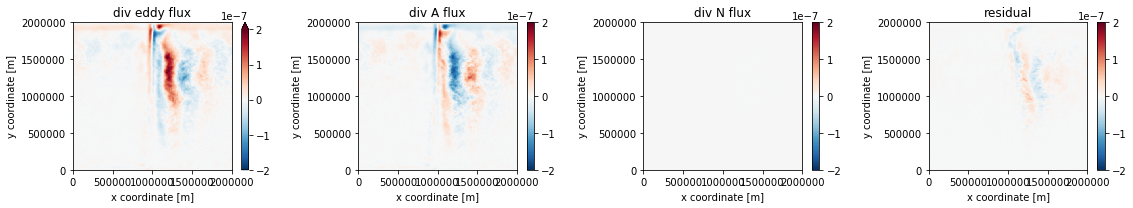

In [171]:
plt.figure(figsize=(16,3))

plt.subplot(141)
div_eddy.sel(Z=-1000, method='nearest').plot(vmin=-2e-7)
plt.title('div eddy flux')

plt.subplot(142)
divAflux.sel(Z=-1000, method='nearest').plot(vmin=-2e-7)
plt.title('div A flux')

plt.subplot(143)
divNflux.sel(Z=-1000, method='nearest').plot(vmin=-2e-7)
plt.title('div N flux')

plt.subplot(144)
(div_eddy + divAflux - divNflux).sel(Z=-1000, method='nearest').plot(vmin=-2e-7)
plt.title('residual')

plt.tight_layout()

As seen above most of the eddy flux divergence can be captured by the skew flux divergence, the rotational flux divergence is zero, and the residual is small - it contains the discretiziation and errors at $O(\alpha^3)$. This is all in the sense of a very long time average, which results in negligible time tendency terms. 

** Next - same analysis but on shorter time scale **

In [332]:
nav = 11
Utav = ds_model.U.coarsen(time=nav, boundary='trim').mean()
Vtav = ds_model.V.coarsen(time=nav, boundary='trim').mean()
Wtav = ds_model.W.coarsen(time=nav, boundary='trim').mean()
Ttav = ds_model['T'].coarsen(time=nav, boundary='trim').mean()

In [333]:
# mean advection
div_mean_tav = (grid.interp(Utav*grid.diff(Ttav, 'X')/ds_mean.dxC, 'X') + 
                grid.interp(Vtav*grid.diff(Ttav, 'Y', boundary='extend')/ds_mean.dyC, 'Y', boundary='extend') 
              - grid.interp(Wtav*grid.diff(Ttav, 'Z', boundary='extend'), 'Z', boundary='extend')/ds_mean.drF)

In [334]:
# tendency 
dTemp = ds_model['T'].diff(dim='time', label='lower')
tendency = dTemp.coarsen(time=nav, boundary='trim').mean()/3/24/3600

In [335]:
# eddy fluxes
UpTptav = ((grid.interp(ds_model.U, 'X')*ds_model['T']).coarsen(time=nav, boundary='trim').mean() 
           - grid.interp(Utav, 'X')*Ttav)

VpTptav = ((grid.interp(ds_model.V, 'Y', boundary='extend')*ds_model['T']).coarsen(time=nav, boundary='trim').mean() 
           - grid.interp(Vtav, 'Y',boundary='extend')*Ttav)

WpTptav = ((grid.interp(ds_model.W, 'Z', boundary='extend')*ds_model['T']).coarsen(time=nav, boundary='trim').mean() 
           - grid.interp(Wtav, 'Z',boundary='extend')*Ttav)

Tfluxtav = xr.Dataset({'UpCp':UpTptav, 'VpCp':VpTptav, 'WpCp':WpTptav})

In [336]:
div_eddy_tav = divergence(Tfluxtav, grid, 5e3)

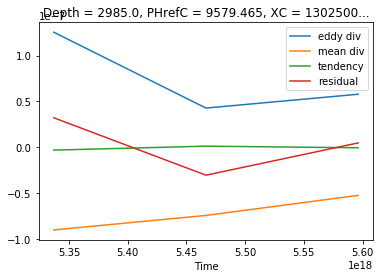

In [288]:
div_eddy_tav.sel(Z=-1000, XC=1300e3, YC=1000e3, method='nearest').plot(label='eddy div')
div_mean_tav.sel(Z=-1000, XC=1300e3, YC=1000e3, method='nearest').plot(label='mean div')
tendency.sel(Z=-1000, XC=1300e3, YC=1000e3, method='nearest').plot(label='tendency')

(tendency+div_eddy_tav+div_mean_tav).sel(Z=-1000, XC=1300e3, YC=1000e3, method='nearest').plot(label='residual')
plt.legend ()

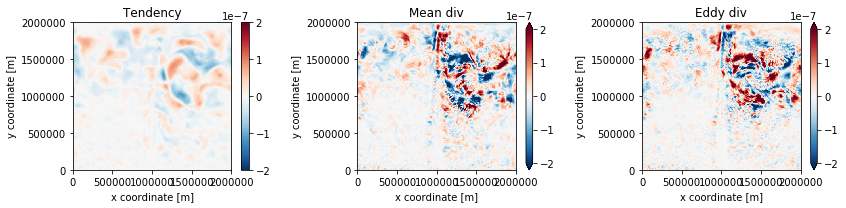

In [322]:
plt.figure(figsize=(12,3))

plt.subplot(131)
tendency.sel(Z=-1000, method='nearest').isel(time=0).plot(vmin=-2e-7)
plt.title('Tendency')

plt.subplot(132)
div_mean_tav.sel(Z=-1000, method='nearest').isel(time=0).plot(vmin=-2e-7)
plt.title('Mean div')

plt.subplot(133)
div_eddy_tav.sel(Z=-1000, method='nearest').isel(time=0).plot(vmin=-2e-7)
plt.title('Eddy div')

plt.tight_layout()

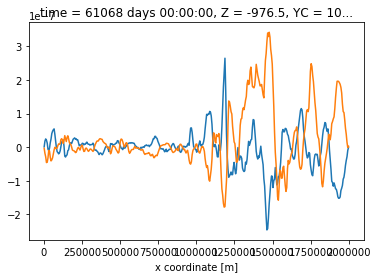

In [323]:
div_mean_tav.sel(YC=1000e3, Z=-1000, method='nearest').isel(time=0).plot()
div_eddy_tav.sel(YC=1000e3, Z=-1000, method='nearest').isel(time=0).plot()

**Note**: At shorter time scales it is harder to close the budget, but we know that since the diabatic contribution is small, things will workout if the calculations were done online. 

Anyways closing the budget is not the main point, and is a pain. We are trying to see how the flux breaks up into the components suggested by the TRM papers. 


In [337]:
phitav = ((ds_model['T']**2).coarsen(time=nav, boundary='trim').mean() - Ttav**2)/2

Ttav_z = - grid.interp(grid.diff(Ttav, 'Z', boundary='extend'), 'Z', boundary='extend')/ Ttav.drF
Ttav_x = grid.interp(grid.diff(Ttav, 'X'), 'X')/ ds_model.dxC[0,0]
Ttav_y = grid.interp(grid.diff(Ttav, 'Y', boundary='extend'), 'Y', boundary='extend')/ ds_model.dyC[0,0]

In [338]:
psixtav = - UpTptav/Ttav_z + 1/Ttav_z * grid.interp(grid.diff(( grid.interp(Utav, 'X') * phitav / Ttav_z),
                                                              'Z', boundary='extend'), 'Z', boundary='extend')/ (-Ttav.drF)

psiytav = - VpTptav/Ttav_z + 1/Ttav_z * grid.interp(grid.diff(( grid.interp(Vtav, 'Y', boundary='extend') * phitav / Ttav_z),
                                                              'Z', boundary='extend'), 'Z', boundary='extend')/ (-Ttav.drF)

In [339]:
Agradbtavx = psixtav*Ttav_z 
Agradbtavy = psiytav*Ttav_z 
Agradbtavz = -psixtav*Ttav_x - psiytav*Ttav_y

Afluxtav = xr.Dataset({'UpCp':Agradbtavx, 'VpCp':Agradbtavy, 'WpCp':Agradbtavz})

In [340]:
Ntavx = grid.interp(grid.diff( 
            grid.interp(Utav,'X')*phitav/Ttav_z, 
            'Z', boundary='extend'), 'Z',boundary='extend')/ (-ds_mean.drF)

Ntavy = grid.interp(grid.diff( 
            grid.interp(Vtav,'Y', boundary='extend')*phitav/Ttav_z, 
            'Z', boundary='extend'), 'Z',boundary='extend')/ (-ds_mean.drF)

Ntavz = -( grid.interp(grid.diff( grid.interp(Utav,'X')*phitav/Ttav_z, 'X'), 'X' )/ (ds_mean.dxC[0,0])+ 
       grid.interp(grid.diff(grid.interp(Vtav,'Y', boundary='extend')*phitav/Ttav_z, 'Y',boundary='extend'), 
                   'Y',boundary='extend')/ (ds_mean.dyC[0,0]))

In [341]:
Nfluxtav = xr.Dataset({'UpCp':Ntavx, 'VpCp':Ntavy, 'WpCp':Ntavz})

In [342]:
divAfluxtav = divergence(Afluxtav, grid, 5e3)
divNfluxtav = divergence(Nfluxtav, grid, 5e3)

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


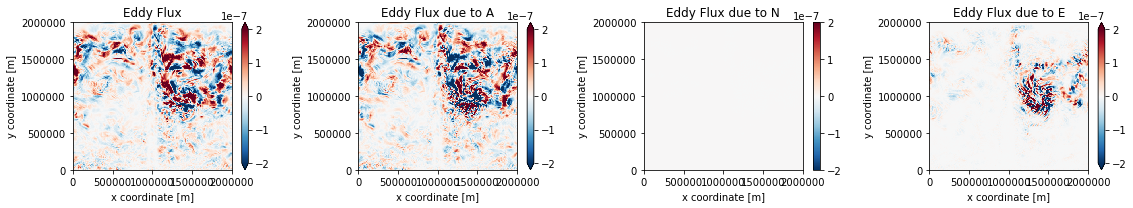

In [343]:
plt.figure(figsize=(16,3))

plt.subplot(141)
div_eddy_tav.sel(Z=-1000, method='nearest').isel(time=0).plot(vmin=-2e-7)
plt.title('Eddy Flux')

plt.subplot(142)
divAfluxtav.sel(Z=-1000, method='nearest').isel(time=0).plot(vmin=-2e-7)
plt.title('Eddy Flux due to A')

plt.subplot(143)
divNfluxtav.sel(Z=-1000, method='nearest').isel(time=0).plot(vmin=-2e-7)
plt.title('Eddy Flux due to N')

plt.subplot(144)
(div_eddy_tav+ divAfluxtav).sel(Z=-1000, method='nearest').isel(time=0).plot(vmin=-2e-7)
plt.title('Eddy Flux due to E')

plt.tight_layout()

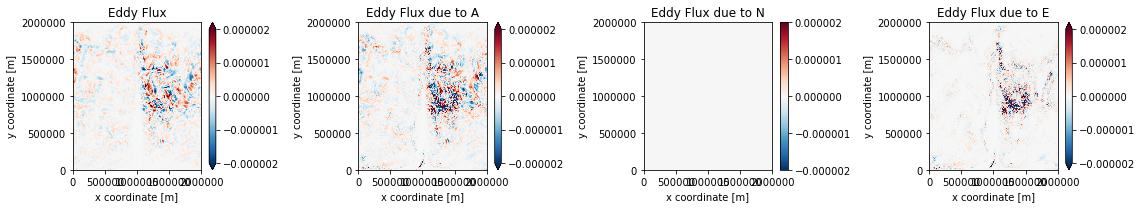

In [346]:
plt.figure(figsize=(16,3))

plt.subplot(141)
div_eddy_tav.sel(Z=-300, method='nearest').isel(time=0).plot(vmin=-2e-6)
plt.title('Eddy Flux')

plt.subplot(142)
divAfluxtav.sel(Z=-300, method='nearest').isel(time=0).plot(vmin=-2e-6)
plt.title('Eddy Flux due to A')

plt.subplot(143)
divNfluxtav.sel(Z=-300, method='nearest').isel(time=0).plot(vmin=-2e-6)
plt.title('Eddy Flux due to N')

plt.subplot(144)
(div_eddy_tav+ divAfluxtav).sel(Z=-300, method='nearest').isel(time=0).plot(vmin=-2e-6)
plt.title('Eddy Flux due to E')

plt.tight_layout()

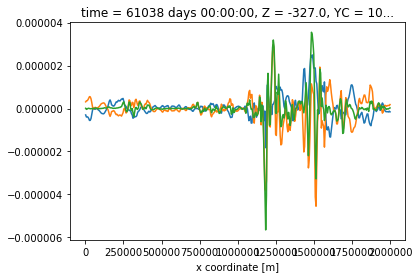

In [345]:
div_eddy_tav.sel(YC=1000e3, Z=-300, method='nearest').isel(time=0).plot()
divAfluxtav.sel(YC=1000e3, Z=-300, method='nearest').isel(time=0).plot()
(div_eddy_tav+ divAfluxtav).sel(YC=1000e3, Z=-300, method='nearest').isel(time=0).plot()

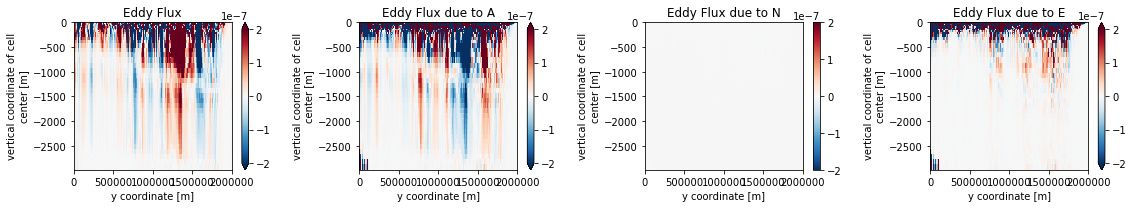

In [349]:
plt.figure(figsize=(16,3))

plt.subplot(141)
div_eddy_tav.sel(XC=0, method='nearest').isel(time=0).plot(vmin=-2e-7)
plt.title('Eddy Flux')

plt.subplot(142)
divAfluxtav.sel(XC=0, method='nearest').isel(time=0).plot(vmin=-2e-7)
plt.title('Eddy Flux due to A')

plt.subplot(143)
divNfluxtav.sel(XC=0, method='nearest').isel(time=0).plot(vmin=-2e-7)
plt.title('Eddy Flux due to N')

plt.subplot(144)
(div_eddy_tav+ divAfluxtav).sel(XC=0, method='nearest').isel(time=0).plot(vmin=-2e-7)
plt.title('Eddy Flux due to E')

plt.tight_layout()

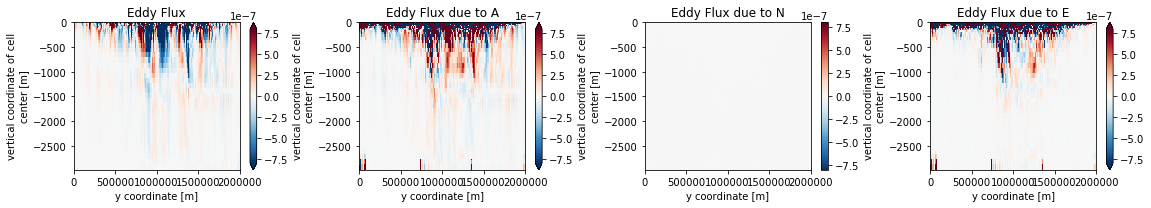

In [352]:
plt.figure(figsize=(16,3))

plt.subplot(141)
div_eddy_tav.sel(XC=1300e3, method='nearest').isel(time=0).plot(vmin=-8e-7)
plt.title('Eddy Flux')

plt.subplot(142)
divAfluxtav.sel(XC=1300e3, method='nearest').isel(time=0).plot(vmin=-8e-7)
plt.title('Eddy Flux due to A')

plt.subplot(143)
divNfluxtav.sel(XC=1300e3, method='nearest').isel(time=0).plot(vmin=-8e-7)
plt.title('Eddy Flux due to N')

plt.subplot(144)
(div_eddy_tav+ divAfluxtav).sel(XC=1300e3, method='nearest').isel(time=0).plot(vmin=-8e-7)
plt.title('Eddy Flux due to E')

plt.tight_layout()

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*args2)
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/numpy/core/_methods.py:38: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


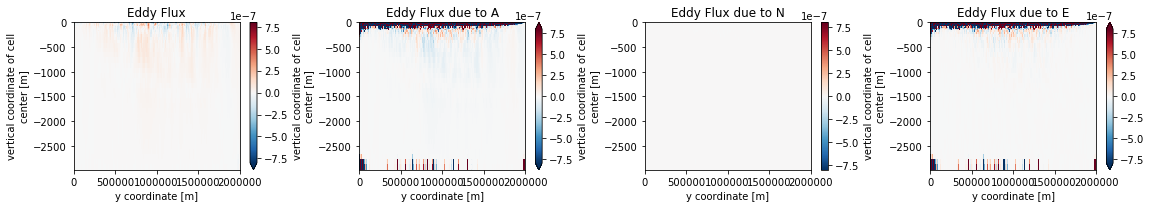

In [355]:
plt.figure(figsize=(16,3))

plt.subplot(141)
div_eddy_tav.sel(XC=1300e3, method='nearest').mean('time').plot(vmin=-8e-7)
plt.title('Eddy Flux')

plt.subplot(142)
divAfluxtav.sel(XC=1300e3, method='nearest').mean('time').plot(vmin=-8e-7)
plt.title('Eddy Flux due to A')

plt.subplot(143)
divNfluxtav.sel(XC=1300e3, method='nearest').mean('time').plot(vmin=-8e-7)
plt.title('Eddy Flux due to N')

plt.subplot(144)
(div_eddy_tav+ divAfluxtav).sel(XC=1300e3, method='nearest').mean('time').plot(vmin=-8e-7)
plt.title('Eddy Flux due to E')

plt.tight_layout()

These figures show that there is divergent flux that results due to E. E is a vertical vector, and is primarily not going to lie along the isopycnals. 


### TRM 2 analysis 

two things change in TRM2. 

The first is the density variable, from time mean ($\overline{b}$) to a density surface ($\tilde{b}$) whose depth will be tracked. 

This introduces a new density equation for $\tilde{b}$. This equation is not forced by the simple density flux, but a modified version. This modified flux can be written entirely in terms of an anti-sym tensor and a non-divergent flux. 


In [358]:
Ttilde = Ttav - grid.interp(grid.diff(phitav/ Ttav_z, 'Z', boundary='extend'), 'Z', boundary='extend')

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in subtract
  return func(*args2)
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in add
  return func(*args2)


Text(0.5, 1.0, 'Different between the temps')

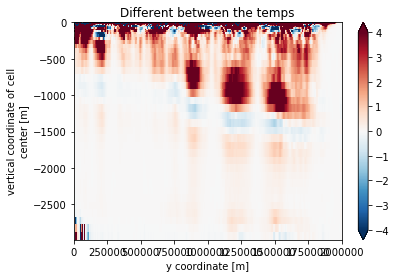

In [363]:
(Ttilde - Ttav).isel(time=0).sel(XC=0, method='nearest').plot(vmin=-4)
plt.title('Difference between the temps')

It is a bit hard to evaluate this because the new density flux has a time derivative in. 
However, maybe in the time average this will go away - think of the way the Sevellec paper does things. 

In [ ]:
# some residual code on time differencing
ds_model.T.isel(time=slice(0, -1, 51)).time.isel(time=slice(0,4))
ds_model.T.isel(time=slice(50, -1, 51)).time.isel(time=slice(0,4))